# When is the optimum point to be born for the Olympics?

I am going to analyse when is the best point in the 4-year Olympiad to have the greatest chance of competing (or medaling) at the olympics.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in data
athlete_df=pd.read_csv("data/athlete_events.csv",index_col="ID")
noc_df=pd.read_csv("data/noc_regions.csv",index_col="NOC")

The only age data is in years only. This means we cannot tell whether two people were born 2 months apart or 23 months apart. This is a big limitation on the analysis.

# Data Cleaning

In [3]:
# drop unnecesary columns
athlete_df=athlete_df.drop(["Height","Weight","Team","Games","City"],axis=1)

In [4]:
# strips event string to remove reference to gender and sport
def clean_event(row):
    event=row["Event"]; sport=row["Sport"]
    event=event.replace(sport,"")
    event=event.replace("women's","")
    event=event.replace("men's","")
    event=event.strip()
    return event if event!="" else np.NaN

In [5]:
# drop rows without age data
print("{} rows without age values removed.".format(athlete_df["Age"].isnull().sum()))
athlete_df=athlete_df[athlete_df["Age"].notnull()].reindex()

9474 rows without age values removed.


### Drop big team sports, sports with little data or are non-physical

In [6]:
# count number of olympic games each sport has appeared at
def games_per_sport(df):
    sport_years_df=pd.pivot_table(data=athlete_df,values="Year",index="Sport",aggfunc=[lambda x:len(list(x.unique()))])
    sport_years_df.columns=["Num_Years"]
    sport_years_df["Num_Years"]=sport_years_df["Num_Years"].astype(int)
    return sport_years_df

In [7]:
# remove big team sports & non-physical sports
non_physical=["Art Competitions","Equestrianism","Polo","Sailing"]
team_sports=["Baseball","Tug-Of-War","Handball","Basketball","Ice Hockey","Hockey","Football","Water Polo"]
athlete_df=athlete_df[~athlete_df["Sport"].isin(non_physical)]
athlete_df=athlete_df[~athlete_df["Sport"].isin(team_sports)]

In [8]:
# remove sports which appeared in less than 10 games
games_per_sport_df=games_per_sport(athlete_df)
common_sports=games_per_sport_df[games_per_sport_df["Num_Years"]>=10]

print("{} rows removed due to sport.".format((~athlete_df["Sport"].isin(common_sports.index)).sum()))
athlete_df=athlete_df[athlete_df["Sport"].isin(common_sports.index)]

12160 rows removed due to sport.


## Standardise Data

In [9]:
# make all strings lowercase
athlete_df[["Name","Season","NOC","Sport","Event","Medal"]]=athlete_df[["Name","Season","NOC","Sport","Event","Medal"]].astype(str)
for col in ["Name","Season","NOC","Sport","Event","Medal"]:
    athlete_df[col]=athlete_df[col].str.lower()
    athlete_df[col]=athlete_df[col].replace("nan",np.NaN)

In [10]:
# Add Fields
athlete_df["Cycle_Age"]=(athlete_df["Age"]%4).astype(int) # Age wrt point in olympic cycle
athlete_df["Medalist"]=athlete_df["Medal"].isin(["gold","silver","bronze"]) # boolean for whether athlete won a medal

# Overview Analysis

In [11]:
print("'athlete_df' contains {} rows covering:".format(athlete_df.shape[0]))
summer_games=athlete_df[athlete_df["Season"]=="summer"]
winter_games=athlete_df[athlete_df["Season"]=="winter"]
print("\t{} summer games ({}-{}) & {} winter games ({}-{}).".format(len(summer_games["Year"].unique()),summer_games["Year"].min(),summer_games["Year"].max(),len(winter_games["Year"].unique()),winter_games["Year"].min(),winter_games["Year"].max()))
print("\t{} sports ({} summer, {} winter).".format(len(athlete_df["Sport"].unique()),len(athlete_df[athlete_df["Season"]=="summer"]["Sport"].unique()),len(athlete_df[athlete_df["Season"]=="winter"]["Sport"].unique())))

both_games_sports=list(set(athlete_df[athlete_df["Season"]=="summer"]["Sport"].unique()) & set(athlete_df[athlete_df["Season"]=="winter"]["Sport"].unique()))
print("\t{} sport{} have appeared in both winter & summer games ({})".format(len(both_games_sports),"" if len(both_games_sports)==1 else "s",",".join(both_games_sports)))
print("\t{} events ({} summer, {} winter).\n".format(len(athlete_df["Event"].unique()),len(athlete_df[athlete_df["Season"]=="summer"]["Event"].unique()),len(athlete_df[athlete_df["Season"]=="winter"]["Event"].unique())))


'athlete_df' contains 204151 rows covering:
	29 summer games (1896-2016) & 22 winter games (1924-2014).
	26 sports (18 summer, 9 winter).
	1 sport have appeared in both winter & summer games (figure skating)
	571 events (493 summer, 81 winter).



# Problem Analysis

## Age Distribution of Medalists vs All Competitors

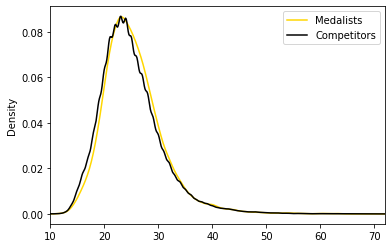

In [12]:
# kde plot of age distribution for medal winners against non-winners
# suggests medal winners are slightly older
xlims=(athlete_df["Age"].min(),athlete_df["Age"].max())
athlete_df[athlete_df["Medalist"]]["Age"].plot.kde(xlim=xlims,label="Medalists",color="gold")
athlete_df["Age"].plot.kde(xlim=xlims,label="Competitors",color="black")
plt.legend()

## Age Distribution when Considering Age wrt point in Olympic Cycle

In [13]:
competitors_cycle_ages_counts=athlete_df["Cycle_Age"].value_counts(normalize=True).sort_index()
medalist_cycle_ages_counts=athlete_df[athlete_df["Medalist"]]["Cycle_Age"].value_counts(normalize=True).sort_index()

# merge data
cycle_age_counts=pd.concat([competitors_cycle_ages_counts,medalist_cycle_ages_counts],axis=1)
cycle_age_counts.columns=["Competitors","Medalists"]
cycle_age_counts

,Competitors,Medalists
0,0.255487,0.252528
1,0.247787,0.248438
2,0.246097,0.249006
3,0.250628,0.250028


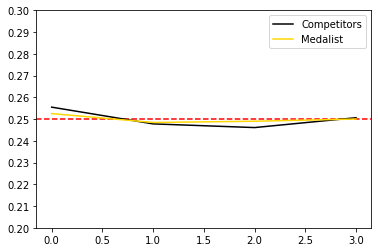

In [14]:
# Visualise results
y_lims=(.2,.3)
plt.axhline(.25,color="red",ls="--")
cycle_age_counts["Competitors"].plot(color="black",label="Competitors",ylim=y_lims)
cycle_age_counts["Medalists"].plot(color="gold",label="Medalist",ylim=y_lims)
plt.yticks([x/100 for x in range(20,31)])
plt.legend()

There is a discrepancy which suggests being born in an olympic year increases the probability of competing and of medaling. Is this discrepancy statistically significant?

## Hypothesis Testing

In [15]:
from scipy.stats import binom

### HYPOTHEIS TEST for probability of binomial RV modelling whether a *medalist* was born in an olympic year.

It has been observed that the probability that an olympic *medalist* was born in an olympic is higher than the expected. Here I perform a hypothesis test to determine whether this value was statistically significant.

Let $X\sim \text{Binom}(n,p)$ model the number of medalists who were born in an olympiad.\
$H_0:p=.25$\
$H_1:p>.25$\
Significance Level: 10%\
It has been observed that out of 36,283 medalists, 9,158 were born in an olympiad.

In [16]:
from scipy.stats import binom

In [17]:
n=athlete_df[athlete_df["Medalist"]].shape[0] # medal winner
obs=athlete_df[athlete_df["Medalist"] & (athlete_df["Cycle_Age"]==0)].shape[0] # medal winner and born in olympiad
print("Num medal winners: {:,}. Num medal winners born in olympiad: {:,} (p={:.4f}).".format(n,obs,obs/n))

expected_p=1/4
p_value=1-binom.cdf(obs,n,expected_p) # H0:p=1/4, H1:p!=1/4
print("p_value={:.8f}. {}Statistically Significant\n".format(p_value,"" if p_value<=.1 else "*Not* "))

Num medal winners: 26,405. Num medal winners born in olympiad: 6,668 (p=0.2525).
p_value=0.16957065. *Not* Statistically Significant



There is **no evidence** that it is more likely that an olympic medalist was born in an olympic year.

### HYPOTHEIS TEST for probability of binomial RV modelling whether a *competitor* was born in an olympic year.

It has been observed that the probability that an olympic *competitor* was born in an olympic is higher than the expected. Here I perform a hypothesis test to determine whether this value was statistically significant.

Let $X\sim \text{Binom}(n,p)$ model the number of medalists who were born in an olympiad.\
$H_0:p=.25$\
$H_1:p>.25$\
Significance Level: 10%\
It has been observed that out of 245,302 medalists, 62,487 were born in an olympiad.

In [18]:
n=athlete_df.shape[0] # competitor
obs=(athlete_df["Cycle_Age"]==0).sum() # competitor and born in olympiad
print("Num competitors: {:,}. Num competitors born in olympiad: {:,} (p={:.4f}).".format(n,obs,obs/n))

expected_p=1/4
p_value=1-binom.cdf(obs,n,expected_p) # H0:p=1/4, H1:p!=1/4
print("p_value={:.8f}. {}Statistically Significant\n".format(p_value,"" if p_value<=.1 else "*Not* "))

Num competitors: 204,151. Num competitors born in olympiad: 52,158 (p=0.2555).
p_value=0.00000001. Statistically Significant



There is *sufficient evidence* that it is more likely that an olympic competitor was born in an olympic year.

### $\chi^2$ TEST for whether distribution of *medalists* ages in olympic cycle is uniform.

Here I use a chi-squared test to determine whether the distribution of normalised ages for olympic *medalists* follows a uniform distribution. It is expected that a quarter of all medalists will be born in each year.

$dof=3$

In [19]:
from scipy.stats import chisquare

In [20]:
f_obs=athlete_df[athlete_df["Medalist"]]["Cycle_Age"].value_counts().sort_index().values
f_exp=np.repeat(sum(f_obs)/4,4)
print("Observed occs: {}. Expected occs: {}".format(f_obs,f_exp))
_,p_value=chisquare(f_obs,f_exp)
print("p_value={:.8f}. {}Statistically Significant\n".format(p_value,"" if p_value<=.1 else "*Not* "))

Observed occs: [6668 6560 6575 6602]. Expected occs: [6601.25 6601.25 6601.25 6601.25]
p_value=0.79225410. *Not* Statistically Significant



There is **no evidence** that the distribution of when olympic medalists where born in an olympiad is not uniform. This indicates that the year you are born does not affect the probability of you winning an olympic medal.

### $\chi^2$ TEST for whether distribution of *competitors* ages in olympic cycle is uniform.

Here I use a chi-squared test to determine whether the distribution of normalised ages for olympic *competitors* follows a uniform distribution. It is expected that a quarter of all competitors will be born in each year.

$dof=3$

In [21]:
f_obs=athlete_df["Cycle_Age"].value_counts().sort_index().values
f_exp=np.repeat(sum(f_obs)/4,4)
print("Observed occs: {}. Expected occs: {}".format(f_obs,f_exp))
_,p_value=chisquare(f_obs,f_exp)
print("p_value={:.8f}. {}Statistically Significant\n".format(p_value,"" if p_value<=.1 else "*Not* "))

Observed occs: [52158 50586 50241 51166]. Expected occs: [51037.75 51037.75 51037.75 51037.75]
p_value=0.00000001. Statistically Significant



There is **sufficient evidence** that the distribution of when olympic athletes where born in an olympiad is **not** uniform. This suggests that being born at the start of an olympiad means you are more likely to compete in an olympics.

## Age Distribution Split By Gender

In [22]:
male_athletes=athlete_df[athlete_df["Sex"]=="M"].copy()
female_athletes=athlete_df[athlete_df["Sex"]=="F"].copy()

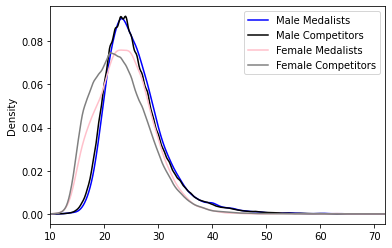

In [23]:
# Distribution of ages of medalists and competitors, split by gender
xlims=(athlete_df["Age"].min(),athlete_df["Age"].max())

# plot male data
male_athletes[male_athletes["Medalist"]]["Age"].plot.kde(xlim=xlims,label="Male Medalists",color="blue")
male_athletes["Age"].plot.kde(xlim=xlims,label="Male Competitors",color="black")

# plot female data
female_athletes[female_athletes["Medalist"]]["Age"].plot.kde(xlim=xlims,label="Female Medalists",color="pink")
female_athletes["Age"].plot.kde(xlim=xlims,label="Female Competitors",color="gray")
plt.legend()

The distribution for men are practically identical. Whereas, the female distributions are notably different and this should be investigated further. Does this discrepency only occur in female dominated sports or does it occur across all sports?

## Age Distribution Split By Sport

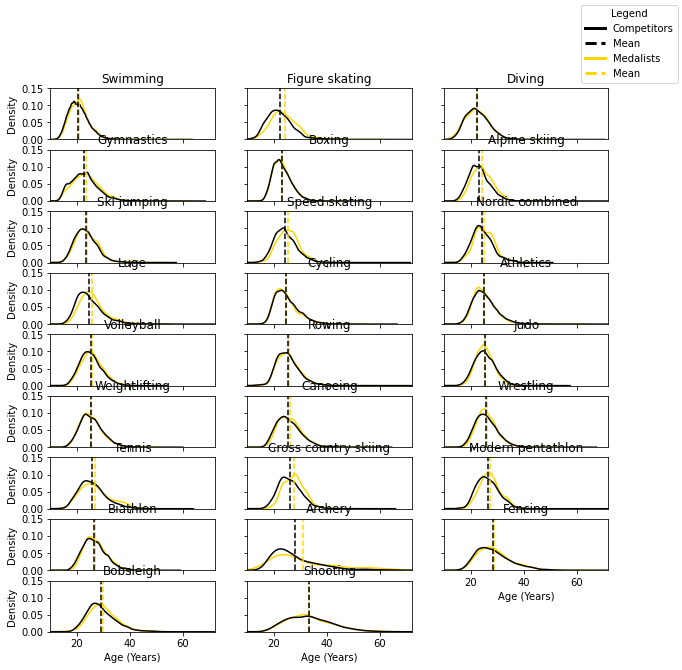

In [24]:
# sort sports by mean age increasing
mean_age_per_sport=athlete_df.groupby(by=["Sport"])["Age"].mean().sort_values()
num_sports=mean_age_per_sport.shape[0]

# plot of age distribution for each sports
fig,axes=plt.subplots(figsize=(10,10),ncols=3,nrows=int(np.ceil(num_sports/3)))

# ensure plots are all same scale
xlims=(athlete_df["Age"].min(),athlete_df["Age"].max())
ylims=(0,.15)

for count,sport in enumerate(list(mean_age_per_sport.index)):
    row_i=count//3; col_i=count%3
    ax=axes[row_i,col_i]
    data=athlete_df[athlete_df["Sport"]==sport]

    # plot data
    data[data["Medalist"]]["Age"].plot.kde(ax=ax,xlim=xlims,ylim=ylims,label="Medalists",color="gold")
    data["Age"].plot.kde(ax=ax,xlim=xlims,ylim=ylims,label="Competitors",color="black")

    # add horizontal line for mean of each
    ax.axvline(x=data[data["Medalist"]]["Age"].mean(),color="gold",ls="--")
    ax.axvline(x=data["Age"].mean(),color="black",ls="--")

    # style plot
    ax.set_title(str.capitalize(sport))
    ax.set_yticks([0,.05,.1,.15])
    if (col_i==0): ax.set_ylabel("Density") # LHS
    else: ax.set_ylabel(""); ax.set_yticklabels([])
    if (count+3>=num_sports): ax.set_xlabel("Age (Years)") # bottom of each column
    else: ax.set_xlabel(""); ax.set_xticklabels([])

# remove excess plots
for i in range(num_sports,3*int(np.ceil(num_sports/3))):
    row_i=i//3; col_i=i%3
    fig.delaxes(axes[row_i,col_i])

# legend data
from matplotlib.lines import Line2D
colors=['black',"black",'gold',"gold"]
style =["-","--","-","--"]
lines =[Line2D([0],[0],linewidth=3,linestyle=style[i],color=colors[i]) for i in range(4)]
labels=["Competitors","Mean","Medalists","Mean"]
fig.legend(lines,labels,title="Legend",loc="upper right")

plt.show()

## Normalise Age split by Sport

In [26]:
# group data by sport
sport_groups=athlete_df.groupby(by=["Sport"])

In [31]:
# prepare data for legend
from matplotlib.lines import Line2D
colors=['gray','black','red']
style =["-","-","--"]
lines =[Line2D([0],[0],linewidth=3,linestyle=style[i],color=colors[i]) for i in range(3)]
labels=["Individual Sport Proportions","Overall Proportion","Expected"]

In [33]:
# data for competitors
prop_func=lambda x,n:list(x).count(n)/len(x)
competitors_sport_cycle_age_pt=pd.pivot_table(data=athlete_df,values="Cycle_Age",index="Sport",aggfunc=(lambda x:prop_func(x,0),lambda x:prop_func(x,1),lambda x:prop_func(x,2),lambda x:prop_func(x,3)))
competitors_sport_cycle_age_pt.columns=["0","1","2","3"]
competitors_cycle_age_mean=athlete_df["Cycle_Age"].value_counts(normalize=True).sort_index()

/home/hutchinson/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


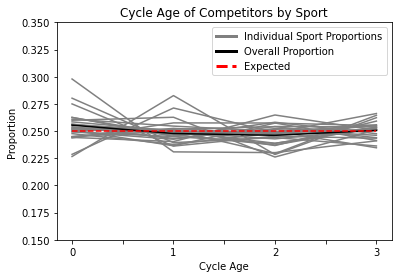

In [28]:
# plot competitor data
# line for normalised age distribution of each sport
competitors_sport_cycle_age_pt.transpose().plot.line(color="gray",ylim=(.15,.35))
plt.xlabel("Cycle Age")
plt.ylabel("Proportion")
plt.title("Cycle Age of Competitors by Sport")
plt.plot(list(competitors_cycle_age_mean.index),competitors_cycle_age_mean.values,color="black") # plot mean values
plt.plot([0,1,2,3], [.25,.25,.25,.25], '--',color="red")

plt.legend(lines,labels)

No consistent pattern among all sports. Most variance occurs with the achievement of those born at the start of an olympiad

In [34]:
# data for medalists
medalists_sport_cycle_age_pt=pd.pivot_table(data=athlete_df[athlete_df["Medalist"]],values="Cycle_Age",index="Sport",aggfunc=(lambda x:prop_func(x,0),lambda x:prop_func(x,1),lambda x:prop_func(x,2),lambda x:prop_func(x,3)))
medalists_sport_cycle_age_pt.columns=["0","1","2","3"]
medalists_cycle_age_mean=athlete_df[athlete_df["Medalist"]]["Cycle_Age"].value_counts(normalize=True).sort_index()

/home/hutchinson/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


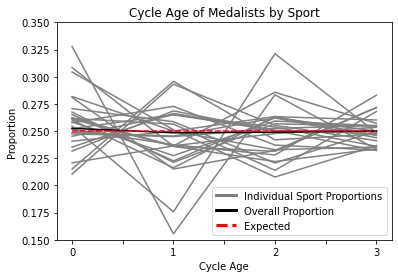

In [35]:
# plot medalists data
medalists_sport_cycle_age_pt.transpose().plot.line(color="gray",ylim=(.15,.35))
plt.plot(list(medalists_cycle_age_mean.index),medalists_cycle_age_mean.values,color="black") # plot mean values
plt.plot([0,1,2,3], [.25,.25,.25,.25], '--',color="red")
plt.xlabel("Cycle Age")
plt.ylabel("Proportion")
plt.title("Cycle Age of Medalists by Sport")

plt.legend(lines,labels)

Lots for variance. Likely due to the smaller sample sizes.